# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [264]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler

import graphviz
from datetime import date
import time
import pyreadr


import os
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchviz import make_dot

import math

# Define functions

In [265]:
# Prediction function
def batch_pred(X,MG):
    global x
    pred_list = []
    batch_size = 512
    x = 0
    for i in range(math.ceil(X.shape[0]/batch_size)):
        with torch.no_grad():
            temp_X = X[x:x+batch_size].to(device)
            temp_MG = MG[x:x+batch_size].to(device)
            
            # For independent multiple inputs
            x0 = temp_X[:,:,0].unsqueeze(1)
            x1 = temp_X[:,:,1].unsqueeze(1)
            x2 = temp_X[:,:,2].unsqueeze(1)
            x3 = temp_X[:,:,3].unsqueeze(1)
            x4 = temp_X[:,:,4].unsqueeze(1)
            x5 = temp_X[:,:,5].unsqueeze(1)
            x6 = temp_X[:,:,6].unsqueeze(1)

            pred = model(x0,x1,x2,x3,x4,x5,x6,temp_MG).detach().cpu().numpy().astype('float').tolist()
        pred_list.extend(pred)
        x = x + batch_size
    return pred_list

# Model Architecture (CNN-LF)

In [266]:
'''Model Architecture'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN_LF(nn.Module):
    def __init__(self):
        super(CNN_LF, self).__init__()
        self.features0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=0),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
#         self.features0 = nn.Sequential(
#             nn.Conv2d(1, 8, 3, 1, 1),
#             nn.MaxPool1d(2),
#             nn.ReLU(),
#         )
        
        self.fc1 = nn.Sequential(
#             nn.Linear(8*3*3,16),
            nn.Linear(424,16),
            nn.ReLU(),
        )
        self.fc2 = nn.Linear(16,1)
        self.fc3 = nn.Sequential(
            nn.Linear(8,128),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(128, 1)
        
    def forward(self, x0, x1, x2, x3, x4, x5, x6, MG):
        x0 = self.features0(x0)
        x1 = self.features0(x1)
        x2 = self.features0(x2)
        x3 = self.features0(x3)
        x4 = self.features0(x4)
        x5 = self.features0(x5)
        x6 = self.features0(x6)
        
        x0 = x0.view(x0.size(0), -1)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x3 = x3.view(x3.size(0), -1)
        x4 = x4.view(x4.size(0), -1)
        x5 = x5.view(x5.size(0), -1)
        x6 = x6.view(x6.size(0), -1)
        
        x0 = self.fc1(x0)
        x1 = self.fc1(x1)
        x2 = self.fc1(x2)
        x3 = self.fc1(x3)
        x4 = self.fc1(x4)
        x5 = self.fc1(x5)
        x6 = self.fc1(x6)
        
        x0 = self.fc2(x0)
        x1 = self.fc2(x1)
        x2 = self.fc2(x2)
        x3 = self.fc2(x3)
        x4 = self.fc2(x4)
        x5 = self.fc2(x5)
        x6 = self.fc2(x6)
        
        x = torch.cat((x0,x1,x2,x3,x4,x5,x6,MG), dim=1)
        x = self.fc3(x)
        x = self.regressor(x)
        return x

In [267]:
# Visualize model architecture
batch_size = 1
x0 = torch.randn(batch_size, 1, 214)
x1 = torch.randn(batch_size, 1, 214)
x2 = torch.randn(batch_size, 1, 214)
x3 = torch.randn(batch_size, 1, 214)
x4 = torch.randn(batch_size, 1, 214)
x5 = torch.randn(batch_size, 1, 214)
x6 = torch.randn(batch_size, 1, 214)
MG = torch.randn(batch_size, 1)

model = CNN_LF()

# summary(model,(channels,H,W))
# summary(model,input_size=[x0.shape[1:4],x1.shape[1:4],x2.shape[1:4],x3.shape[1:4]])
print(model)

# Visualize the architecture using make_dot
model2 = CNN_LF()
yDummy = model2(x0, x1, x2, x3, x4, x5, x6, MG)
make_dot(yDummy, params=dict(model.named_parameters()))

# Visualize the architecture using Netron
dummy_input = x0,x1,x2,x3,x4,x5,x6,MG
model.to('cpu')
torch.onnx.export(model, dummy_input,'./cnn_lf.onnx', input_names=['x0','x1','x2','x3','x4','x5','x6','MG'], output_names='y')

CNN_LF(
  (features0): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=424, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (fc3): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
  )
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)


In [268]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)

# Standardization prcess
scaler_x0 = StandardScaler().fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = StandardScaler().fit(Weather_train[:,:,1])
scaled_x1 = scaler_x0.transform(Weather_train[:,:,1])
scaler_x2 = StandardScaler().fit(Weather_train[:,:,2])
scaled_x2 = scaler_x0.transform(Weather_train[:,:,2])
scaler_x3 = StandardScaler().fit(Weather_train[:,:,3])
scaled_x3 = scaler_x0.transform(Weather_train[:,:,3])
scaler_x4 = StandardScaler().fit(Weather_train[:,:,4])
scaled_x4 = scaler_x0.transform(Weather_train[:,:,4])
scaler_x5 = StandardScaler().fit(Weather_train[:,:,5])
scaled_x5 = scaler_x0.transform(Weather_train[:,:,5])
scaler_x6 = StandardScaler().fit(Weather_train[:,:,6])
scaled_x6 = scaler_x0.transform(Weather_train[:,:,6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])
# data2.alpha = scaler_alpha.transform(data2[['alpha']]) # For actual test dataset
    
#####################################
# Load training and validation data #
#####################################
# 30% is val, 70% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.8, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.8, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

MG_train, MG_val = train_test_split(MG, test_size=0.8, shuffle=True, random_state=888)
MG_val, MG_test = train_test_split(MG_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''

# Transform into tensor
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

Y_train = Y_train.view(-1,1)
Y_val = Y_val.view(-1,1)
Y_test = Y_test.view(-1,1)


MG_train = MG_train.astype('float')
MG_val = MG_val.astype('float')
MG_test = MG_test.astype('float')

MG_train = torch.from_numpy(MG_train).int()
MG_val = torch.from_numpy(MG_val).int()
MG_test = torch.from_numpy(MG_test).int()

In [269]:
# Check the sample size for each state
df = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
tab = df.groupby(['State']).size()
tab

State
"AL"     2980
"AR"     5030
"DE"      303
"GA"     3775
"IA"     4331
"IL"     5578
"IN"     5711
"KS"     5766
"KY"      973
"LA"     1068
"MAN"     126
"MD"     1571
"MI"     2946
"MN"     5264
"MO"     5384
"MS"     2751
"NC"     3747
"ND"     1412
"NE"     9218
"OH"     3770
"OK"     1088
"ONT"    4726
"QUE"    2183
"SC"     2196
"SD"     3959
"TN"     3448
"TX"      558
"VA"     3166
dtype: int64

In [270]:
#################
# Train process #
#################

model = CNN_LF()
model.to(device)

counter = 0 # For earlystop

PATIENCE = 10
EPOCH = 1000 # 500
BATCH_SIZE = 512

losses = []
torch.manual_seed(123)    # reproducible

loss_func = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(), lr=0.005)#default is 0.001

# Dataloader
train_len = X_train.size()[0]
val_len = X_val.size()[0]
test_len = X_test.size()[0]

X = X_train
Y = Y_train
MG = MG_train
trainset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_val
Y = Y_val
MG = MG_val
valset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_test
Y = Y_test
MG = MG_test
testset = torch.utils.data.TensorDataset(X, MG, Y)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
data_loaders = {"train": train_loader, "val": validation_loader, "test":test_loader}
data_lengths = {"train": train_len, "val": val_len, "test": test_len}

losses_train = []
losses_val = []
losses_test = []

for epoch in range(EPOCH):
    print('Epoch {}/{}'.format(epoch + 1, EPOCH))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val', 'test']:
        if phase == 'train':
            #optimizer = scheduler(optimizer, epoch)
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:

            # get the input images and their corresponding labels
            X, MG, Y = data

            # flatten pts
            #key_pts = key_pts.view(key_pts.size(0), -1)

            # wrap them in a torch Variable
            X, MG, Y = Variable(X), Variable(MG), Variable(Y)

            # convert variables to floats for regression loss
            Y = Y.type(torch.cuda.FloatTensor)
            X = X.type(torch.cuda.FloatTensor)
            MG = MG.type(torch.cuda.FloatTensor)

            # For independent inputs
            x0 = X[:,:,0].unsqueeze(1)
            x1 = X[:,:,1].unsqueeze(1)
            x2 = X[:,:,2].unsqueeze(1)
            x3 = X[:,:,3].unsqueeze(1)
            x4 = X[:,:,4].unsqueeze(1)
            x5 = X[:,:,5].unsqueeze(1)
            x6 = X[:,:,6].unsqueeze(1)

            # forward pass to get outputs
            outputs = model(x0,x1,x2,x3,x4,x5,x6,MG)

            # calculate the loss between predicted and target keypoints
            loss = loss_func(outputs, Y)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.data.item() #[0]

        epoch_loss = running_loss / data_lengths[phase]

        if phase == 'train':
            losses_train.append(epoch_loss)
        elif phase =='val':
            losses_val.append(epoch_loss)
            # Earlystopping
            if epoch == 0:
                best_score = epoch_loss
            else:
                best_score = min(losses_val)
                if losses_val[-1] > best_score:
                    counter += 1
                elif losses_val[-1] == best_score:
                    counter = 0
                    filepath = './model/CNN_LF_BestModel.pth'
                    torch.save(model.state_dict(), filepath) # save the best-score model
        else:
            losses_test.append(epoch_loss)
                    
        if phase == 'train':
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
        elif phase == 'val':
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('Counter: {}'.format(counter))
            print('-' * 10)

    # Earlystopping
    if counter == PATIENCE:
        print("Early Stopping!")
        print('---Training completed at the {}th epoch'.format(epoch+1))
        break

Epoch 1/1000
train Loss: 1.5500
val Loss: 0.5052
Counter: 0
----------
Epoch 2/1000
train Loss: 0.5175
val Loss: 0.4972
Counter: 0
----------
Epoch 3/1000
train Loss: 0.4968
val Loss: 0.4798
Counter: 0
----------
Epoch 4/1000
train Loss: 0.4695
val Loss: 0.4451
Counter: 0
----------
Epoch 5/1000
train Loss: 0.4349
val Loss: 0.4139
Counter: 0
----------
Epoch 6/1000
train Loss: 0.4123
val Loss: 0.4003
Counter: 0
----------
Epoch 7/1000
train Loss: 0.3978
val Loss: 0.3900
Counter: 0
----------
Epoch 8/1000
train Loss: 0.3872
val Loss: 0.3815
Counter: 0
----------
Epoch 9/1000
train Loss: 0.3752
val Loss: 0.3670
Counter: 0
----------
Epoch 10/1000
train Loss: 0.3597
val Loss: 0.3565
Counter: 0
----------
Epoch 11/1000
train Loss: 0.3489
val Loss: 0.3412
Counter: 0
----------
Epoch 12/1000
train Loss: 0.3316
val Loss: 0.3262
Counter: 0
----------
Epoch 13/1000
train Loss: 0.3190
val Loss: 0.3116
Counter: 0
----------
Epoch 14/1000
train Loss: 0.3028
val Loss: 0.3033
Counter: 0
----------
E

Epoch 115/1000
train Loss: 0.1311
val Loss: 0.1386
Counter: 1
----------
Epoch 116/1000
train Loss: 0.1340
val Loss: 0.1351
Counter: 2
----------
Epoch 117/1000
train Loss: 0.1308
val Loss: 0.1416
Counter: 3
----------
Epoch 118/1000
train Loss: 0.1334
val Loss: 0.1448
Counter: 4
----------
Epoch 119/1000
train Loss: 0.1318
val Loss: 0.1377
Counter: 5
----------
Epoch 120/1000
train Loss: 0.1309
val Loss: 0.1348
Counter: 0
----------
Epoch 121/1000
train Loss: 0.1309
val Loss: 0.1342
Counter: 0
----------
Epoch 122/1000
train Loss: 0.1291
val Loss: 0.1352
Counter: 1
----------
Epoch 123/1000
train Loss: 0.1293
val Loss: 0.1399
Counter: 2
----------
Epoch 124/1000
train Loss: 0.1314
val Loss: 0.1350
Counter: 3
----------
Epoch 125/1000
train Loss: 0.1315
val Loss: 0.1342
Counter: 4
----------
Epoch 126/1000
train Loss: 0.1301
val Loss: 0.1395
Counter: 5
----------
Epoch 127/1000
train Loss: 0.1293
val Loss: 0.1365
Counter: 6
----------
Epoch 128/1000
train Loss: 0.1349
val Loss: 0.1350


# Check the best model

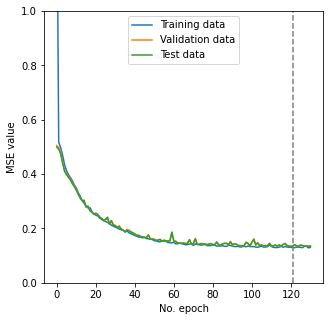

Train


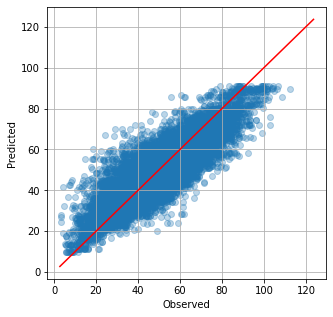

Validation


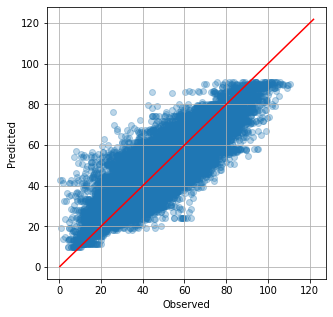

Test


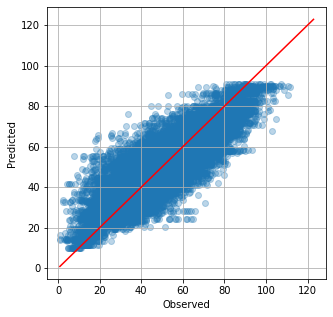

Train RMSE: 7.97
Train MAE: 6.08
Train R2: 0.752
Validation RMSE: 8.27
Validation MAE: 6.30
Validation R2: 0.732
Test RMSE: 8.26
Test MAE: 6.31
Test R2: 0.730


In [271]:
# Loss function
plt.figure(figsize=(5,5))
plt.plot(losses_train,label='Training data') 
plt.plot(losses_val,label='Validation data') 
plt.plot(losses_test,label='Test data') 

plt.axvline(x=epoch+1-PATIENCE, ls='--', color='grey')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend()
plt.ylim([0,1])
plt.show()

# Prediction
# Resnet is required to be put in evaluation mode in order 
# to do prediction / evaluation
model = CNN_LF()
model.to(device)
model.load_state_dict(torch.load(filepath))
model.eval()

import math

pred_train = batch_pred(X_train,MG_train)
pred_val = batch_pred(X_val,MG_val)
pred_test = batch_pred(X_test,MG_test)
            
# Plotting model results
print("Train")
plt.figure(figsize=(5,5))
plt.scatter(Y_train.cpu().numpy(), pred_train, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_train).item(), 1.1*max(Y_train).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Validation")
plt.figure(figsize=(5,5))
plt.scatter(Y_val.cpu().numpy(), pred_val, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_val).item(), 1.1*max(Y_val).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test")
plt.figure(figsize=(5,5))
plt.scatter(Y_test.cpu().numpy(), pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_test).item(), 1.1*max(Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Train RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_train.cpu().numpy(), pred_train))))
print("Train MAE: %.2f" % (mean_absolute_error(Y_train.cpu().numpy(), pred_train)))
print("Train R2: %.3f" % (r2_score(Y_train.cpu().numpy(), pred_train)))

print("Validation RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_val.cpu().numpy(), pred_val))))
print("Validation MAE: %.2f" % (mean_absolute_error(Y_val.cpu().numpy(), pred_val)))
print("Validation R2: %.3f" % (r2_score(Y_val.cpu().numpy(), pred_val)))

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_test.cpu().numpy(), pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(Y_test.cpu().numpy(), pred_test)))
print("Test R2: %.3f" % (r2_score(Y_test.cpu().numpy(), pred_test)))

# 1. Model perfomance from the original paper
## Including All & Temporal Attention
- RMSE = 7.226
- MAE = 5.441
- Rsq = 0.795

## Including All & SVR-RBF
- RMSE = 7.875
- MAE = 5.976
- Rsq = 0.758

# 2. MLYakuza scores

Note that we don't have actual test dataset. So it's impossible to compare the score values with the original paper.

## LF-CNN 1st trial (Sep 24, 2021)
- RMSE = 8.26
- MAE = 6.31
- Rsq = 0.730